<a target="_blank" href="https://colab.research.google.com/github/jay-gleeson/graduation-prediction-csuf/blob/main/data_science.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Import packages for dataframe and data manipulation.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
import os
import kagglehub

# Download dataframe directly from Kaggle.
path = kagglehub.dataset_download("goldenoakresearch/us-acs-mortgage-equity-loans-rent-statistics")

# Walk through current directory to locate the imported csv file.
real_estate_db_path = None
for root, dirs, files in os.walk(path):
    if "real_estate_db.csv" in files:
        real_estate_db_path = os.path.join(root, "real_estate_db.csv")
        break

if real_estate_db_path is None:
    raise ValueError("real_estate_db.csv not found in the downloaded dataset")

In [ ]:
# Import dataframe, encoding='latin-1' is for properly reading csv.
df = pd.read_csv(real_estate_db_path, encoding='latin-1')
df.head()

,UID,BLOCKID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
0,220336,NaN,140,16,2,Alaska,AK,Unalaska,Unalaska City,City,...,32.78177,31.91667,19.31875,440.46429,1894.0,0.25053,0.47388,0.30134,0.03443,0.09802
1,220342,NaN,140,20,2,Alaska,AK,Eagle River,Anchorage,City,...,38.97956,39.66667,20.05513,466.65478,1947.0,0.94989,0.52381,0.01777,0.00782,0.13575
2,220343,NaN,140,20,2,Alaska,AK,Jber,Anchorage,City,...,22.20427,23.16667,13.86575,887.67805,3570.0,0.00759,0.50459,0.06676,0.01000,0.01838
3,220345,NaN,140,20,2,Alaska,AK,Anchorage,Point Mackenzie,City,...,37.00750,34.00000,22.06347,281.49420,1049.0,0.20247,0.44428,0.05933,0.00000,0.21563
4,220347,NaN,140,20,2,Alaska,AK,Anchorage,Anchorage,City,...,34.96611,31.75000,20.49887,655.98066,2905.0,0.56936,0.51034,0.08315,0.06731,0.08711


# Clean data, remove outliers, and sample reasonable amount of dataframe.

In [ ]:
from scipy import stats

# Drop duplicate rows.
df.drop_duplicates(subset=None, inplace=True)

# Drop nAn row.
df.drop('BLOCKID', axis=1, inplace=True)

# Replace all items containing non-readable characters with nAn, then drops all nAn rows.
df.replace(r'^\s*$', np.nan, regex=True)
df = df.dropna(axis=0)

# Drop rows containing items that are beyond three standard deviations.
for i in ['hs_degree','debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']:
    df = df[np.abs(stats.zscore(df[i])) < 3]

# Sample 1% of data within dataframe.
df_sampled = df.sample(frac=0.01)
df_sampled.head()

,UID,SUMLEVEL,COUNTYID,STATEID,state,state_ab,city,place,type,primary,...,female_age_mean,female_age_median,female_age_stdev,female_age_sample_weight,female_age_samples,pct_own,married,married_snp,separated,divorced
7019,233716,140,7,9,Connecticut,CT,Centerbrook,Essex Village,CDP,tract,...,49.37623,53.58333,24.29009,796.33709,3390.0,0.82387,0.59978,0.02454,0.01913,0.12559
37706,291875,140,57,53,Washington,WA,La Conner,La Conner,Town,tract,...,44.33796,47.66667,25.68470,446.98809,1875.0,0.72183,0.63580,0.04398,0.01543,0.13889
10489,240144,140,181,13,Georgia,GA,Lincolnton,Lincolnton City,City,tract,...,41.25882,43.58333,23.51196,481.21712,1963.0,0.73627,0.49932,0.03420,0.03420,0.12722
22110,262268,140,109,31,Nebraska,NE,Lincoln,Walton,Village,tract,...,47.78346,51.58333,23.04377,798.17265,3537.0,0.89836,0.69087,0.00519,0.00000,0.04322
32696,282419,140,149,47,Tennessee,TN,Murfreesboro,Murfreesboro City,City,tract,...,36.56321,39.66667,21.32437,598.36330,2211.0,0.93841,0.63559,0.05266,0.00000,0.08111


# Create heatmap to display correlations between columns.

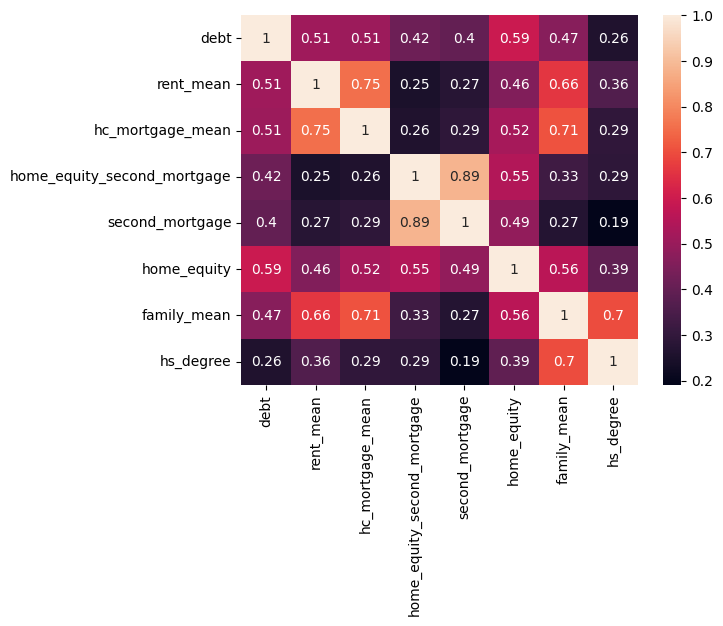

In [ ]:
import seaborn as sb

# Render heatmap to find highest correlation columns.
data = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean', 'hs_degree']]
dataplot=sb.heatmap(data.corr(), annot=True)

# Define, and run Neural Network model.

In [ ]:
# Define X and y variables for training.
# X is the whole data correlating with the target y, the high school degree percentage.
data_no_hs_degree = df_sampled[['debt', 'rent_mean', 'hc_mortgage_mean', 'home_equity_second_mortgage', 'second_mortgage', 'home_equity', 'family_mean']]
X = data_no_hs_degree
y = df_sampled['hs_degree']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data into 80% training data and 20% testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

# Define neural network model.
# One input layer, two relu activation layers, and one linear activation layer to prevent overfitting.
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='linear'))

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define learning rate limiter and Adam optimizer.
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

# Define learning rate schedule.
def lr_scheduler(epoch):
    return initial_learning_rate * 0.95 ** epoch
lr_callback = LearningRateScheduler(lr_scheduler)

# Compile model and print results per epoch.
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
model.fit(StandardScaler().fit_transform(X_train), y_train, batch_size = 1, epochs = 100, callbacks=[lr_callback])

Epoch 1/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3450 - mae: 0.4649 - learning_rate: 0.0010
Epoch 2/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0386 - mae: 0.1604 - learning_rate: 9.5000e-04
Epoch 3/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0198 - mae: 0.1133 - learning_rate: 9.0250e-04
Epoch 4/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0145 - mae: 0.0975 - learning_rate: 8.5737e-04
Epoch 5/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0099 - mae: 0.0837 - learning_rate: 8.1451e-04
Epoch 6/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - mae: 0.0719 - learning_rate: 7.7378e-04
Epoch 7/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0062 - mae: 0.0636 - learning_rate: 7.3509e-04
Epoch 8/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059 - mae: 0.0626 - learning_rate: 6.9834e-04
Epoch 9/100
279/279 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0047 - mae: 0.0547 - learning_rate: 6.6342e-04
Epoch 10/100


In [ ]:
# Predict y using untrained on, 20% of data previously split.
y_pred = model.predict(StandardScaler().fit_transform(X_test))

# Define Mean Percent Error metric.
def mean_percent_error(y_test, y_pred):
    y_test = tf.cast(tf.reshape(y_test, [-1]), dtype=tf.float32)
    y_pred = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)
    mpe = tf.abs(tf.reduce_mean((y_test - y_pred) / y_test) * 100)
    return mpe

# R-squared metric, closer to 1 means greater accuracy.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.3f}")

# Mean Absolute Error metric, closer to 0 means less error.
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Root Mean Squared Error metric, closer to 0 means less error.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Mean Percent Error metric, lower error means greater prediction accuracy.
mpe = mean_percent_error(y_test, y_pred)
print(f"Mean Percent Error: {mpe:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
R-squared: 0.293
Mean Absolute Error: 0.0674
Root Mean Squared Error: 0.0844
Mean Percent Error: 0.59%


# Define and render Decision Tree Regression model.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Define X and y variables.
# X and y are data predicting target y data.
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['hs_degree']

# Split data into 80% training data and 20% testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Decision Tree Regression model.
regressor = DecisionTreeRegressor(random_state=42, max_depth=5)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# R-squared metric, closer to 1 means greater accuracy.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.3f}")

# Mean Absolute Error metric, closer to 0 means less error.
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Root Mean Squared Error metric, closer to 0 means less error.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Mean Percent Error metric, lower error means greater prediction accuracy.
mpe = mean_percent_error(y_test, y_pred)
print(f"Mean Percent Error: {mpe:.2f}%")

R-squared: 0.486
Mean Absolute Error: 0.0536
Root Mean Squared Error: 0.0768
Mean Percent Error: 1.32%


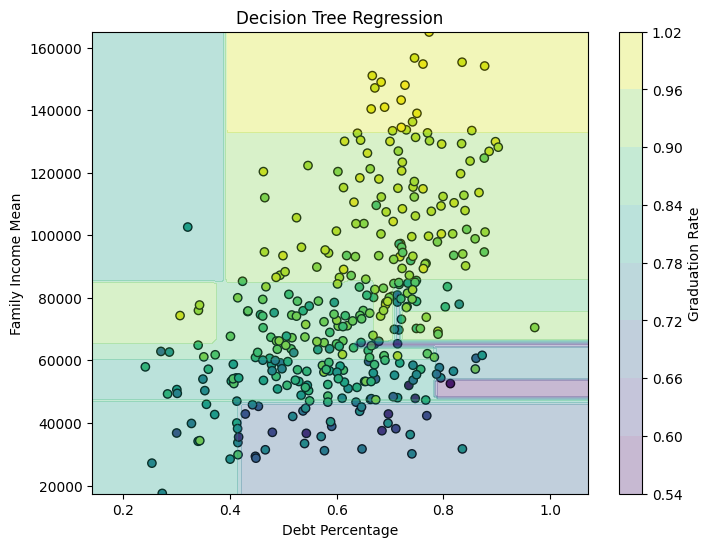

In [ ]:
import matplotlib.pyplot as plt

# Plot Regression Tree.
plt.figure(figsize=(8, 6))
plt.scatter(X['debt'], X['family_mean'], c=y, cmap='viridis', edgecolors='k')
xx, yy = np.meshgrid(np.linspace(X['debt'].min() - 0.1, X['debt'].max() + 0.1, 100), np.linspace(X['family_mean'].min() - 100, X['family_mean'].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = regressor.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Decision Tree Regression')
plt.colorbar(label='Graduation Rate')
plt.show()

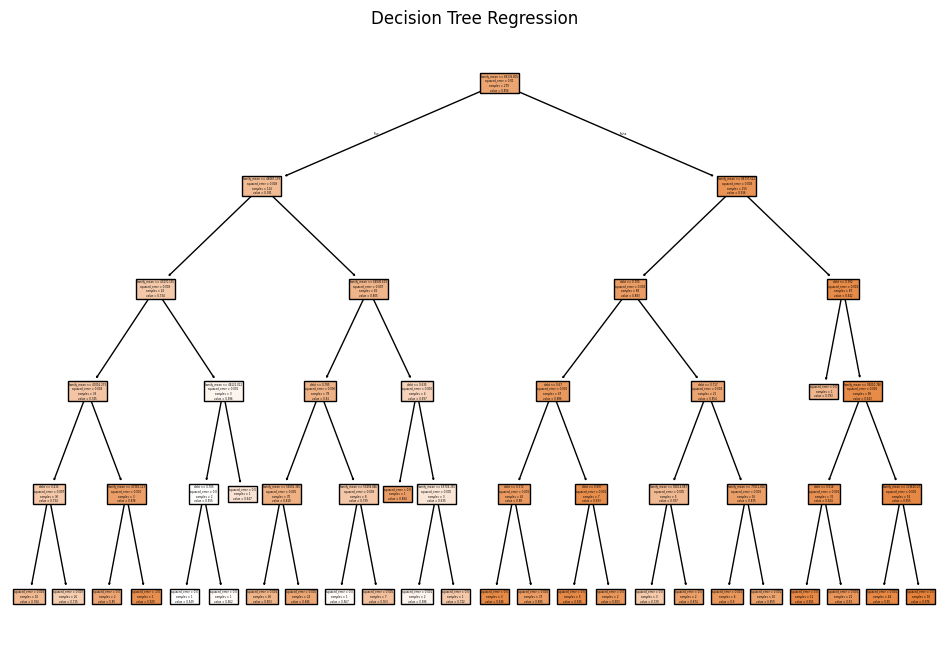

In [ ]:
from sklearn.tree import plot_tree

# Plot Decision Tree.
plt.figure(figsize=(12, 8))
plot_tree(regressor, filled=True, feature_names=X.columns)
plt.title('Decision Tree Regression')
plt.show()

# Define and render Random Forest Regression model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define X and y variables.
# X and y are data predicting target y data.
X = df_sampled[['debt', 'family_mean']]
y = df_sampled['hs_degree']

# Split data into 80% training data and 20% testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Random Forest Regression model.
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

# R-squared metric, closer to 1 means greater accuracy.
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2:.3f}")

# Mean Absolute Error metric, closer to 0 means less error.
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Root Mean Squared Error metric, closer to 0 means less error.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

# Mean Percent Error metric, lower error means greater prediction accuracy.
mpe = mean_percent_error(y_test, y_pred)
print(f"Mean Percent Error: {mpe:.2f}%")

R-squared: 0.544
Mean Absolute Error: 0.0540
Root Mean Squared Error: 0.0723
Mean Percent Error: 0.14%


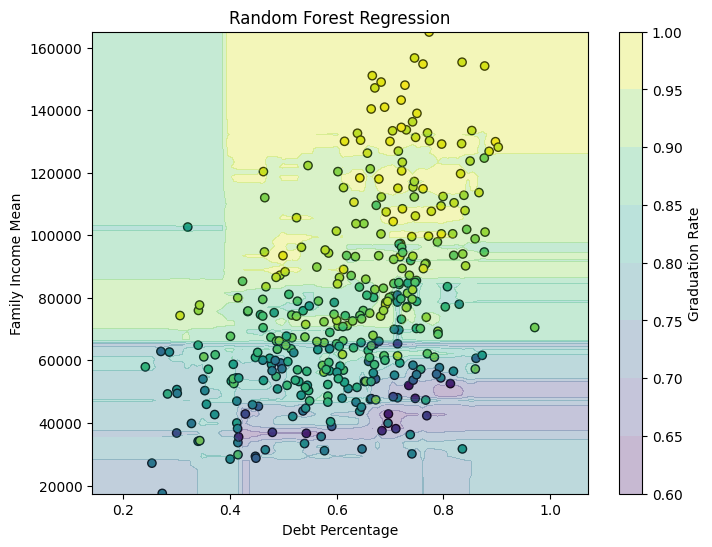

In [ ]:
# Plot Random Forest.
plt.figure(figsize=(8, 6))
plt.scatter(X['debt'], X['family_mean'], c=y, cmap='viridis', edgecolors='k')
xx, yy = np.meshgrid(np.linspace(X['debt'].min() - 0.1, X['debt'].max() + 0.1, 100), np.linspace(X['family_mean'].min() - 100, X['family_mean'].max() + 100, 100))
grid_df = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns)
Z = regressor.predict(grid_df).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.xlabel('Debt Percentage')
plt.ylabel('Family Income Mean')
plt.title('Random Forest Regression')
plt.colorbar(label='Graduation Rate')
plt.show()

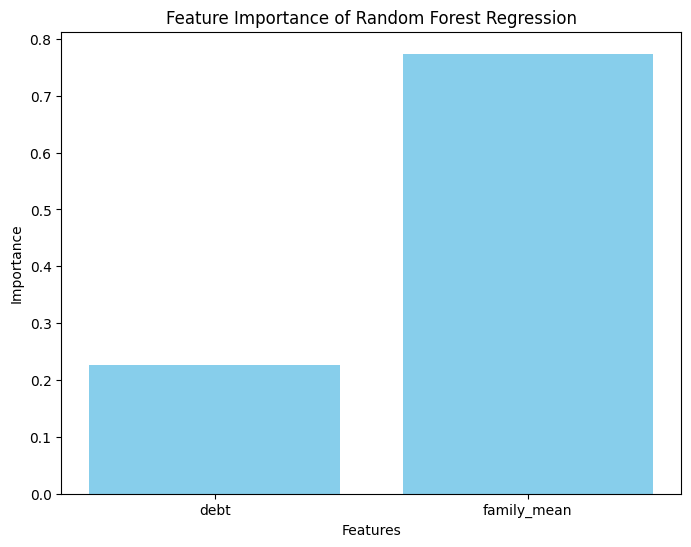

In [ ]:
# Plot Feature Importance
plt.figure(figsize=(8, 6))
plt.bar(X.columns, regressor.feature_importances_, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance of Random Forest Regression')
plt.show()

# Create Interactive High School Degree Rate Map.

In [ ]:
import plotly.express as px

avg_grad_rates = df.groupby('state_ab')['hs_degree'].mean().reset_index()
fig = px.choropleth(avg_grad_rates, locations='state_ab', locationmode='USA-states', color='hs_degree', hover_name='state_ab', color_continuous_scale='blues', title='Average High School Graduation Rates by State')
fig.update_layout(geo_scope='usa')
fig.show()

# Scatterplot of Degree Percentage versus Debt Percentage.

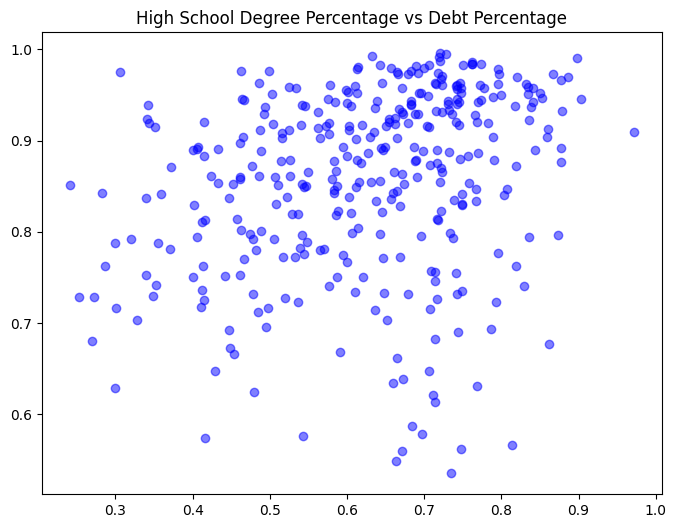

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['debt'], df_sampled['hs_degree'], color='b', alpha=0.5)
plt.title('High School Degree Percentage vs Debt Percentage')
plt.show()

# Line Chart of Graduation Rate versus Debt Percentage.

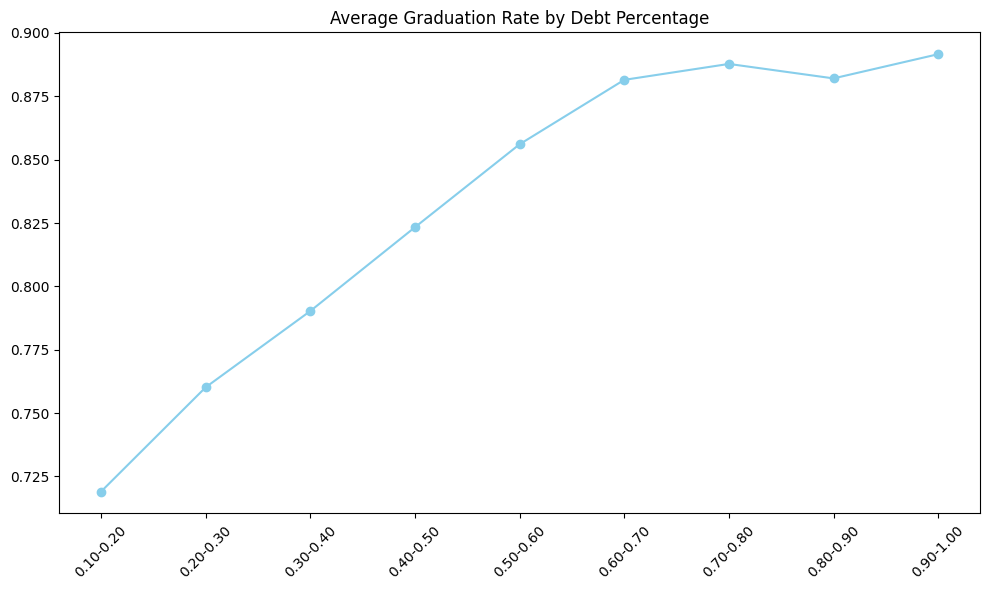

In [ ]:
bins = np.linspace(0, 1, 11)
labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]
df['debt_binned'] = pd.cut(df['debt'], bins=bins, labels=labels, right=False)
avg_graduation_rate = df.groupby('debt_binned', observed=True)['hs_degree'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_graduation_rate.index, avg_graduation_rate.values, marker='o', linestyle='-', color='skyblue')
plt.title('Average Graduation Rate by Debt Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pair Plot of Rent Mean versus Graduation Rate.

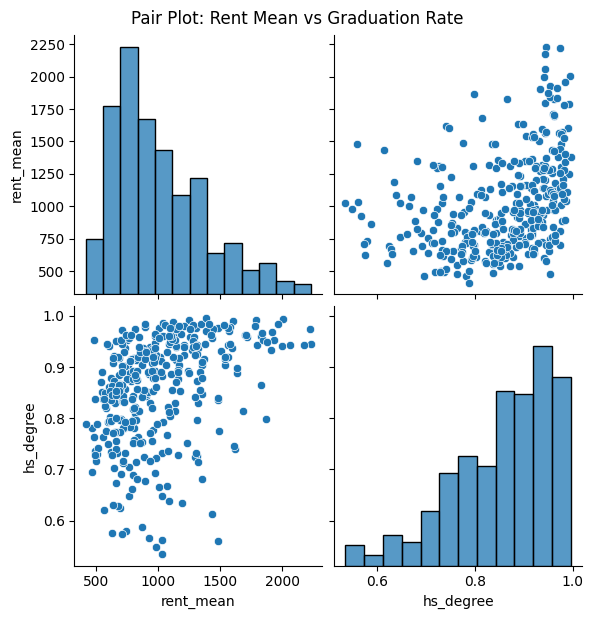

In [ ]:
sb.pairplot(df_sampled[['rent_mean', 'hs_degree']], height=3)
plt.suptitle('Pair Plot: Rent Mean vs Graduation Rate', y=1.02)
plt.show()

# Joint Plot of Mortgage Mean versus Graduation Rate.

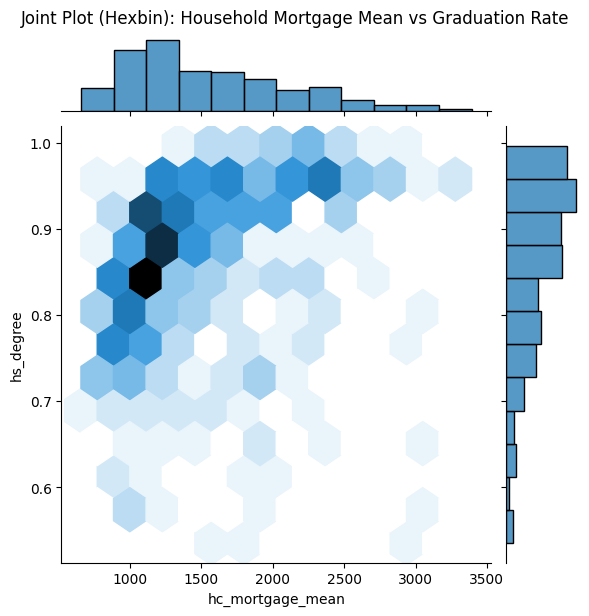

In [ ]:
sb.jointplot(x='hc_mortgage_mean', y='hs_degree', data=df_sampled, kind='hex', height=6)
plt.suptitle('Joint Plot (Hexbin): Household Mortgage Mean vs Graduation Rate', y=1.02)
plt.show()

# Scatter Plot of Family Income Mean versus Graduation Rate.

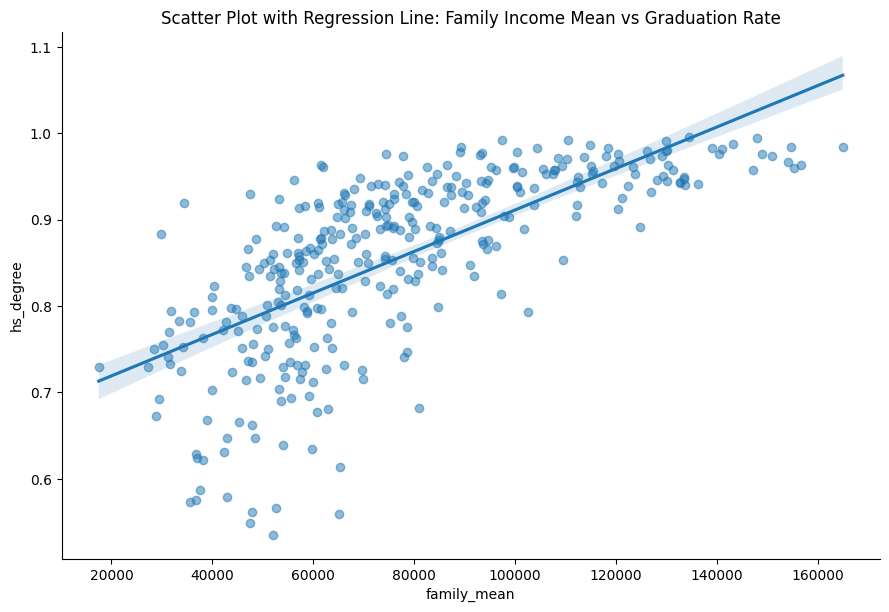

In [ ]:
sb.lmplot(x='family_mean', y='hs_degree', data=df_sampled, height=6, aspect=1.5, scatter_kws={'alpha':0.5})
plt.title('Scatter Plot with Regression Line: Family Income Mean vs Graduation Rate')
plt.show()